# Research Challenge

```{admonition} Margaret Atwood
:class: tip
Every aspect of human technology has a dark side, including the bow and arrow
```

## 🏅 Build your own model 

You have been assigned one dataset from [MatBench](https://matbench.materialsproject.org) as introduced in the [Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-lecture9-challenge). You are free to choose and tune any machine-learning model, with any Python library, but it should be appropriate for the problem. For instance, [XGBoost](https://xgboost.readthedocs.io) could be a good starting starting point to build a regression model. You can refer back to earlier notebooks and repurpose code as needed. 

You may reach the limits of computing processing power on Google Colab. Building a useful model with limited resources is a real-world skill. Using other free resources is allowed if you find an alternative service, as is running on your own computer. A model tracker such as [wandb](https://wandb.ai) could be helpful for advanced users. If you want to try a brute force approach, a library such as [Automatminer](https://hackingmaterials.lbl.gov/automatminer) may be of interest.

This notebook should be used for keeping a record of your model development, submission, and even your presentation. You are free to edit (add/remove/delete) or rearrange the cells as you see fit.

### Your details

In [1]:
import numpy as np

# Insert your values
Name = "Abhi Rajendran" # Replace with your name
CID = 1712516 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
This is the work of Abhi Rajendran [CID: 1712516]


## Problem statement

You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark. 

In [2]:
# Spare cell

#Performing classification on glasses - gfa: Target variable. Glass forming ability: 1 means glass forming and corresponds to amorphous, 0 means non full glass forming.


## Data preparation

Check the data distribution and apply appropriate pre-processing steps as required.

In [3]:
# Get dataset info from matminer
from matminer.datasets import get_all_dataset_info
from matminer.datasets import load_dataset

  # D (GTA - Yifan)
info = get_all_dataset_info("matbench_glass")

# Check out the info about the dataset.
print(info)

Dataset: matbench_glass
Description: Matbench v0.1 test dataset for predicting full bulk metallic glass formation ability from chemical formula. Retrieved from "Nonequilibrium Phase Diagrams of Ternary Amorphous Alloys,’ a volume of the Landolt– Börnstein collection. Deduplicated according to composition, ensuring no compositions were reported as both GFA and not GFA (i.e., all reports agreed on the classification designation). For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	gfa: Target variable. Glass forming ability: 1 means glass forming and corresponds to amorphous, 0 means non full glass forming.
Num Entries: 5680
Reference: Y. Kawazoe, T. Masumoto, A.-P. Tsai, J.-Z. Yu, T. Aihara Jr. (1997) Y. Kawazoe, J.-Z. Yu, A.-P. Tsai, T. Masumoto (ed.) SpringerMaterials
Nonequilibrium Phase Diagrams of Ternary Amorphous All

In [4]:
# module imports 
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation with DataFrames
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualisation

# Load dataset into a pandas DataFrame
df = load_dataset("matbench_glass")
df

Reading file /opt/anaconda3/envs/glasses_classes/lib/python3.10/site-packages/matminer/datasets/matbench_glass.json.gz: 0it [00:00, ?it/s]0, ?it/s]


,composition,gfa
0,Al,False
1,Al(NiB)2,True
2,Al10Co21B19,True
3,Al10Co23B17,True
4,Al10Co27B13,True
...,...,...
5675,ZrTi9,False
5676,ZrTiSi2,True
5677,ZrTiSi3,True
5678,ZrVCo8,True


In [5]:
df.describe()

,composition,gfa
count,5680,5680
unique,5680,2
top,Al,True
freq,1,4035


In [116]:
from matminer.featurizers.composition.composite import ElementProperty
from pymatgen.core import Composition
from sklearn.preprocessing import MinMaxScaler

class DataProcessor:
    def __init__(self, embedding="magpie"):
        self.embedding = embedding
        self.featuriser = ElementProperty.from_preset(preset_name='magpie')
        self.featuriser.set_n_jobs(1)
    
    def featurise_composition(self, df):
        # Create a copy of the dataframe
        data = df.copy()
        print(f"Using {self.embedding} embedding for composition featurisation.")
        
        onehot_df = composition_featuriser(data["composition"], embedding=self.embedding, stats=["sum"])
        onehot_df.drop(columns=['formula'], inplace=True)  # Drop the original composition column
        
        return onehot_df
    
    def featurise_with_pymatgen(self, df, col_id='composition'):
        df["composition_pmg"] = df[col_id].map(Composition)
        df_pmg = self.featuriser.featurize_dataframe(df, col_id='composition_pmg')
        return df_pmg
    
    def scale_data(self, df):
        # Create a copy of the dataframe
        data = df.copy()

        # Get the numerical columns
        numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
        print(f"Scaling the following columns: {numerical_cols}")

        # Scale the data
        scaler = MinMaxScaler()
        data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

        return data


# Create an instance of the DataProcessor class
data_processor = DataProcessor(embedding="magpie")

# Featurise the composition
featurised_data = data_processor.featurise_with_pymatgen(df)

# Scale the featurised data
scaled_data = data_processor.scale_data(featurised_data)

# Create a copy of the scaled data for further processing
processed_data = scaled_data.copy()


ElementProperty: 100%|██████████| 5680/5680 [00:12<00:00, 469.10it/s]


Scaling the following columns: Index(['MagpieData minimum Number', 'MagpieData maximum Number',
       'MagpieData range Number', 'MagpieData mean Number',
       'MagpieData avg_dev Number', 'MagpieData mode Number',
       'MagpieData minimum MendeleevNumber',
       'MagpieData maximum MendeleevNumber',
       'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber',
       ...
       'MagpieData range GSmagmom', 'MagpieData mean GSmagmom',
       'MagpieData avg_dev GSmagmom', 'MagpieData mode GSmagmom',
       'MagpieData minimum SpaceGroupNumber',
       'MagpieData maximum SpaceGroupNumber',
       'MagpieData range SpaceGroupNumber', 'MagpieData mean SpaceGroupNumber',
       'MagpieData avg_dev SpaceGroupNumber',
       'MagpieData mode SpaceGroupNumber'],
      dtype='object', length=132)


In [7]:
processed_data

,composition,gfa,composition_pmg,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Al,False,(Al),0.150000,0.0125,0.000000,0.072975,0.000000,0.120000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.991111,0.885714,0.000000,0.960342,0.000000,0.936508
1,Al(NiB)2,True,"(Al, Ni, B)",0.016667,0.2000,0.294872,0.115235,0.299240,0.013333,0.818182,...,0.282089,0.118423,0.270805,0.000000,0.728889,0.885714,0.259912,0.707386,0.275832,0.000000
2,Al10Co21B19,True,"(Al, Co, B)",0.016667,0.1875,0.282051,0.115839,0.287417,0.306667,0.772727,...,0.733642,0.323387,0.714861,0.733642,0.728889,0.885714,0.259912,0.580480,0.174397,0.444444
3,Al10Co23B17,True,"(Al, Co, B)",0.016667,0.1875,0.282051,0.129120,0.289968,0.306667,0.772727,...,0.733642,0.354186,0.728947,0.733642,0.728889,0.885714,0.259912,0.592484,0.163458,0.444444
4,Al10Co27B13,True,"(Al, Co, B)",0.016667,0.1875,0.282051,0.155684,0.282119,0.306667,0.772727,...,0.733642,0.415783,0.728947,0.733642,0.728889,0.885714,0.259912,0.616494,0.136342,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5675,ZrTi9,False,"(Zr, Ti)",0.300000,0.3500,0.230769,0.235979,0.099338,0.240000,0.545455,...,0.000011,0.000010,0.000004,0.000011,0.853333,0.000000,0.000000,0.628069,0.000000,0.444444
5676,ZrTiSi2,True,"(Zr, Ti, Si)",0.166667,0.3500,0.333333,0.216358,0.268273,0.133333,0.545455,...,0.000011,0.000003,0.000008,0.000000,0.853333,0.942857,0.145374,0.804924,0.160707,0.968254
5677,ZrTiSi3,True,"(Zr, Ti, Si)",0.166667,0.3500,0.333333,0.190700,0.250184,0.133333,0.545455,...,0.000011,0.000002,0.000007,0.000000,0.853333,0.942857,0.145374,0.840295,0.154279,0.968254
5678,ZrVCo8,True,"(Zr, V, Co)",0.316667,0.3500,0.217949,0.297860,0.074197,0.306667,0.560606,...,0.733642,0.615975,0.469531,0.733642,0.853333,1.000000,0.154185,0.665584,0.061361,0.444444


In [8]:

combined_data = processed_data.drop(columns=["composition", "composition_pmg"])
print(combined_data.shape)

(5680, 133)


In [9]:
X = combined_data.drop(columns=["gfa"])
y = combined_data["gfa"]

For those with a larger dataset, you could hit some resource limits such as not enough memory. Here is an approach to reduce the computational burden:

## Model choice 

Define your model and justify your choice based on the problem and available data. You can look back at earlier notebooks and investigate other examples online.

In [10]:
# Data Handling and Visualization
import seaborn as sns  # Visualization library based on matplotlib

# Model Selection and Evaluation
from sklearn.model_selection import cross_val_score  # Cross-validation
from sklearn.model_selection import KFold, StratifiedKFold  # K-Fold CV
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit  # ShuffleSplit CV
from sklearn.model_selection import train_test_split  # Split arrays or matrices into random train and test subsets
from sklearn.metrics import accuracy_score  # Accuracy classification score
from sklearn.metrics import confusion_matrix  # Compute confusion matrix to evaluate accuracy of a classification

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, SGDClassifier  # Linear models for classification
from sklearn.svm import SVC  # C-Support Vector Classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble methods
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier  # More ensemble methods
from sklearn.neighbors import KNeighborsClassifier  # Classifier implementing the k-nearest neighbors vote
from sklearn.tree import DecisionTreeClassifier  # Decision Tree Classifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB  # Naive Bayes classifiers for Gaussian and multinomial models
from sklearn.neural_network import MLPClassifier  # Multi-layer Perceptron classifier
from xgboost import XGBClassifier  # Gradient Boosting for classification from XGBoost library



# create a list of models
models = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    XGBClassifier(),
    SGDClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    ExtraTreesClassifier(),
    GaussianNB(),
    MultinomialNB(),  # Note: MultinomialNB is typically used for discrete features (e.g., word counts for text classification)
    MLPClassifier(),  # Neural network classifier
]

# create a function to perform cross validation
def cross_validate_models(models, X, y, cv=5):
    results = []
    for model in models:
        kfold = StratifiedShuffleSplit(n_splits=cv, random_state=42)
        scores = cross_val_score(model, X, y, cv=kfold)
        results.append({"model": model.__class__.__name__,
                        "mean_accuracy": np.mean(scores),
                        "std_accuracy": np.std(scores)})
    return pd.DataFrame(results)

# cross validate the models
cross_val_results = cross_validate_models(models, X, y)
cross_val_results.sort_values(by="mean_accuracy", ascending=False)


/opt/anaconda3/envs/glasses_classes/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/glasses_classes/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

,model,mean_accuracy,std_accuracy
2,RandomForestClassifier,0.891901,0.008880
5,XGBClassifier,0.890845,0.008977
9,ExtraTreesClassifier,0.890493,0.011101
4,DecisionTreeClassifier,0.867606,0.013287
7,GradientBoostingClassifier,0.858451,0.011057
3,KNeighborsClassifier,0.854225,0.009276
12,MLPClassifier,0.851056,0.005293
8,AdaBoostClassifier,0.827817,0.012419
1,SVC,0.816549,0.008866
0,LogisticRegression,0.800352,0.006358


In [11]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

class ModelOptimizer:
    def __init__(self, classifier, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2):
        """
        Initializes the ModelOptimizer with a classifier, parameter grid, and other settings for GridSearchCV.
        
        Parameters:
        - classifier: The machine learning classifier to optimize.
        - param_grid: The hyperparameter grid to search over.
        - cv: The number of cross-validation folds.
        - scoring: The scoring method to use.
        - n_jobs: The number of jobs to run in parallel.
        - verbose: The verbosity level.
        """
        self.classifier = classifier
        self.param_grid = param_grid
        self.cv = cv
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.grid_search = None
        self.best_model = None

    def fit(self, X_train, y_train):
        """
        Fits the GridSearchCV to find the best hyperparameters and retrains the classifier on the entire training set.
        
        Parameters:
        - X_train: Training features.
        - y_train: Training labels.
        """
        self.grid_search = GridSearchCV(estimator=self.classifier, param_grid=self.param_grid,
                                        cv=self.cv, n_jobs=self.n_jobs, verbose=self.verbose,
                                        scoring=self.scoring)
        self.grid_search.fit(X_train, y_train)
        self.best_model = self.classifier.set_params(**self.grid_search.best_params_)
        self.best_model.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        """
        Evaluates the best model on the test set and prints out various metrics.
        
        Parameters:
        - X_test: Test features.
        - y_test: Test labels.
        """
        y_pred = self.best_model.predict(X_test)
        roc_auc = roc_auc_score(y_test, y_pred)
        print(f"\n ROC AUC: {roc_auc}")
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        #1 means glass forming and corresponds to amorphous, 0 means non full glass forming.

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=["Non-full glass", "Amorphous"]).plot(values_format='d', cmap='Blues')
        plt.show()


    def get_best_params(self):
        """
        Returns the best parameters found by GridSearchCV.
        """
        return self.grid_search.best_params_ if self.grid_search else None
    
    def shap_feature_importance(self, X_test):
        """
        Plots the SHAP feature importance for the best model.
        
        Parameters:
        - X_test: Test features.
        """
        
        import shap

        # Create Tree Explainer object that can calculate shap values
        explainer = shap.TreeExplainer(self.best_model)

        # Compute SHAP values
        shap_values = explainer.shap_values(X_test)

        # Summary plot
        shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
        #shap.force_plot(explainer.expected_value, shap_values, X_test.columns, link='logit', matplotlib=True)
        #shap.force_plot(explainer.expected_value, shap_values[932], X_input.iloc[932])

        return self.best_model
"""
        choosen_instance_index = 932
        if choosen_instance_index in X_test.index:
            choosen_instance = X_test.loc[[choosen_instance_index]]
            shap_values = explainer.shap_values(choosen_instance)
            shap.initjs()
            return shap.force_plot(explainer.expected_value, shap_values, choosen_instance)
        else:
            print(f"Index {choosen_instance_index} not found in X_test")

"""   
       

    
    



'\n        choosen_instance_index = 932\n        if choosen_instance_index in X_test.index:\n            choosen_instance = X_test.loc[[choosen_instance_index]]\n            shap_values = explainer.shap_values(choosen_instance)\n            shap.initjs()\n            return shap.force_plot(explainer.expected_value, shap_values, choosen_instance)\n        else:\n            print(f"Index {choosen_instance_index} not found in X_test")\n\n'

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel

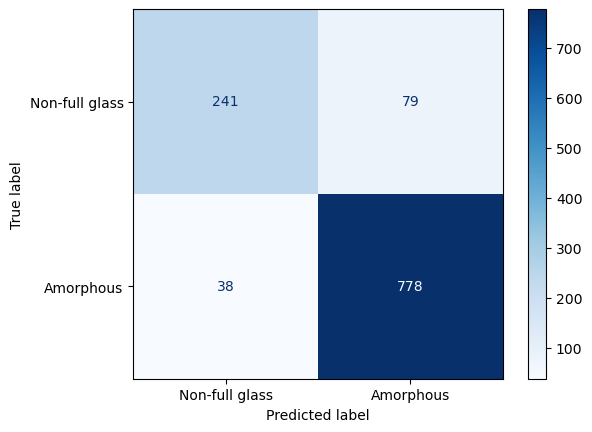

{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [123]:
# Example classifier and parameter grid
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
param_grid = {
    'n_estimators': [50],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True, False]
}

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize, fit, and evaluate the model optimizer
model_optimizer = ModelOptimizer(classifier, param_grid)
model_optimizer.fit(X_train, y_train)
model_optimizer.evaluate(X_test, y_test)
print(model_optimizer.get_best_params())


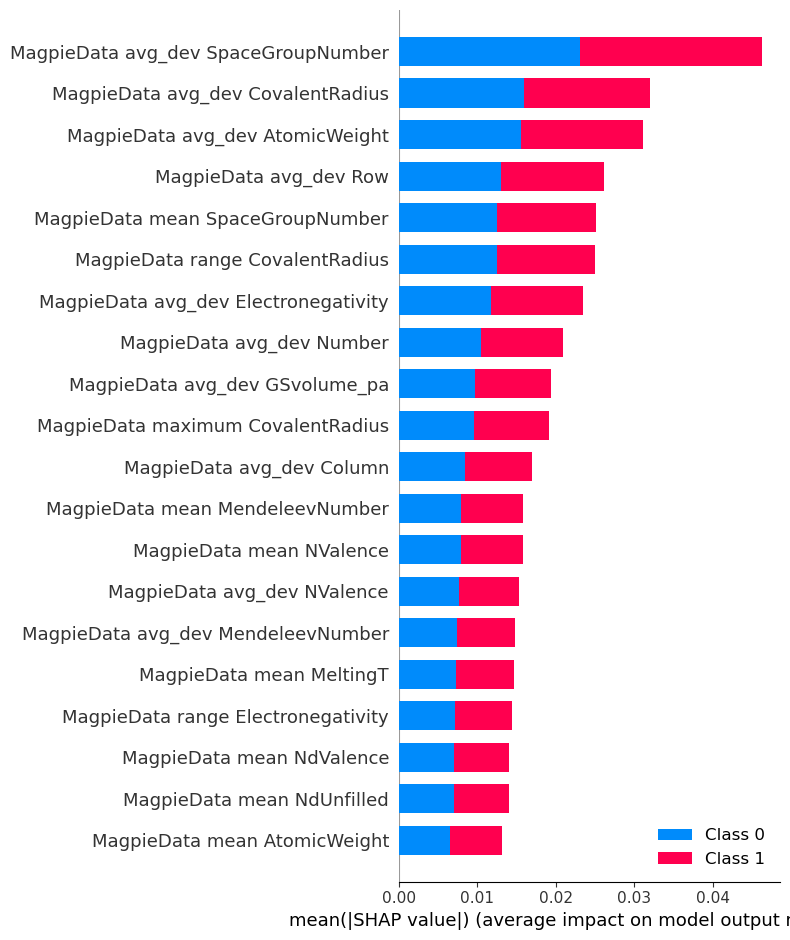

In [125]:
test_mod = model_optimizer.shap_feature_importance(X_test)


In [50]:



import shap

# Compute SHAP values for the first instance in the test set
shap_values_instance = explainer.shap_values(X_test.iloc[0])

# Get the expected value (this is the average model output over the training dataset)
expected_value = explainer.expected_value

# Create a force plot
shap.force_plot(expected_value[0], shap_values_instance[0], X_test.iloc[0])




In [143]:
import warnings

explainer = shap.TreeExplainer(test_mod)
expected_value = explainer.expected_value
print(f"Explainer expected value: {expected_value}")
expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")


#if isinstance(expected_value, list):
#    expected_value = expected_value[1]
#    print("We are in the isinstance loop")
#print(f"Explainer expected value: {expected_value}")

#select 20 random instances from the test set
select = np.random.choice(X_test.index, 20, replace=False)
print(f"Selected instances: {select}")

features = X_test.loc[select]

#select = range(20)
#features = X_test.iloc[select]
#drop composition gfa composition_pmg from featurised_data so it is the same dimensions as X_test
plot_data = featurised_data.drop(columns=["gfa", "composition_pmg", "composition"])
features_display = plot_data.loc[features.index]



Explainer expected value: [0.29159331 0.70840669]
Explainer expected value: 0.7084066901408449
Selected instances: [4648 3429   43 4619 2584  746 1844 4812 4063 5025 4614 1769  416 2399
 5409 1454 2373 3955  925 4122]


In [144]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
    print(f"SHAP values shape: {shap_values.shape}")
    print(f"SHAP interaction values length: {len(shap_interaction_values)}")
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    print("We are in the isinstance loop")

SHAP values shape: (20, 132)
SHAP interaction values length: 2
We are in the isinstance loop


expected_value 0.7084066901408449
SHAP values: (20, 132)


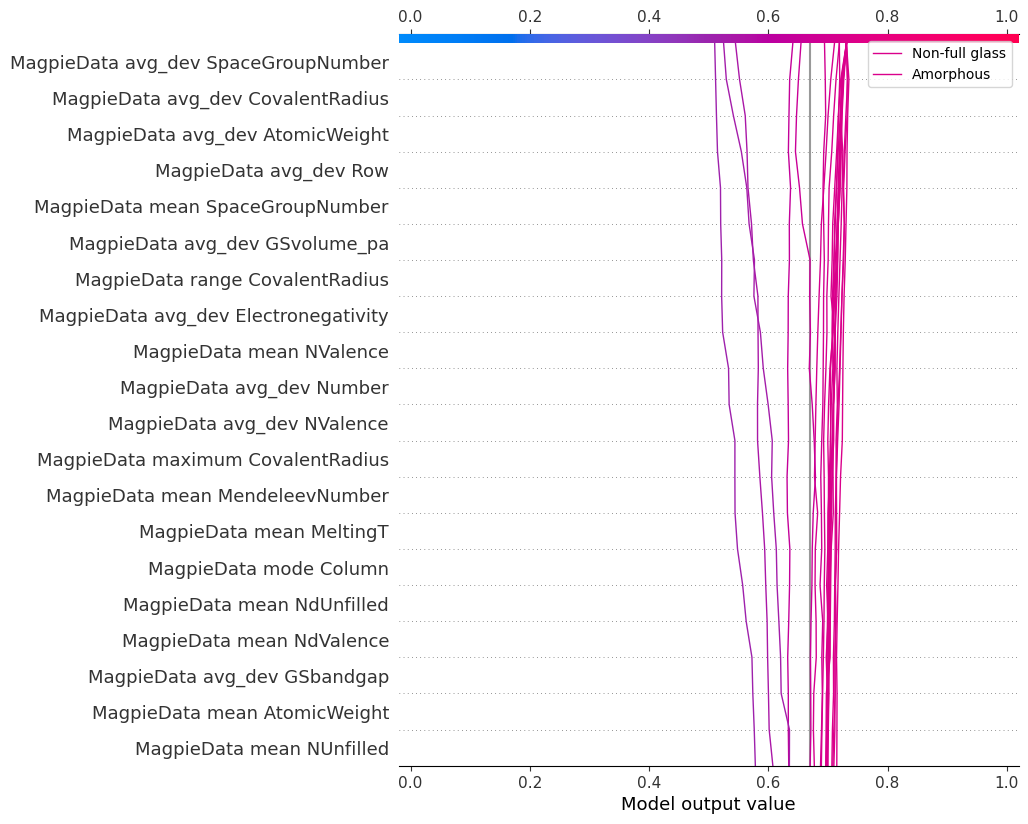

In [145]:
print("expected_value", expected_value)
print(f"SHAP values: {shap_values.shape}")
shap.decision_plot(expected_value, shap_values, plot_data, link='logit' , legend_labels = ['Non-full glass', 'Amorphous'])

Using MPS device
Input dimension: 132
Epoch 1/30, Training Loss: 0.5232289836440288, Validation Loss: 0.46177611417240566
Epoch 2/30, Training Loss: 0.4678637918452142, Validation Loss: 0.44041399823294747
Epoch 3/30, Training Loss: 0.44434402694164865, Validation Loss: 0.43525516821278465
Epoch 4/30, Training Loss: 0.43790160686197416, Validation Loss: 0.4151181032260259
Epoch 5/30, Training Loss: 0.43379691956748423, Validation Loss: 0.43678716321786243
Epoch 6/30, Training Loss: 0.43008079537203614, Validation Loss: 0.4525688605176078
Epoch 7/30, Training Loss: 0.4189215277282285, Validation Loss: 0.41322678824265796
Epoch 8/30, Training Loss: 0.41302908222440265, Validation Loss: 0.40432332621680367
Epoch 9/30, Training Loss: 0.39756167396693165, Validation Loss: 0.41053952111138237
Epoch 10/30, Training Loss: 0.4036590037211566, Validation Loss: 0.4024701068798701
Epoch 11/30, Training Loss: 0.4039854407310486, Validation Loss: 0.4123169117503696
Epoch 12/30, Training Loss: 0.3947

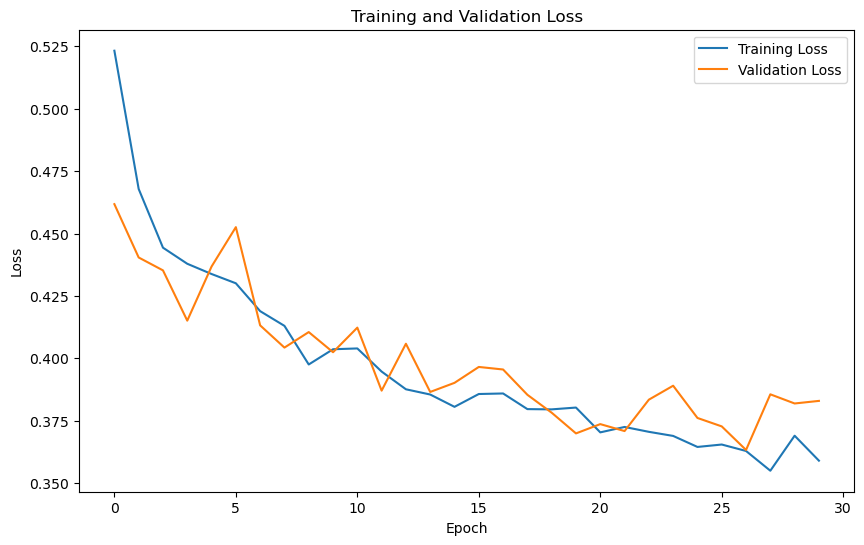

Accuracy: 0.8397887323943662
ROC AUC: 0.7640625
              precision    recall  f1-score   support

       False       0.79      0.59      0.68       320
        True       0.85      0.94      0.89       816

    accuracy                           0.84      1136
   macro avg       0.82      0.76      0.78      1136
weighted avg       0.84      0.84      0.83      1136



In [ ]:
# pytorch neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau



# Set the batch size
batch_size = 64

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    

# Check if MPS is available
if torch.backends.mps.is_available():
    # Set the device to MPS
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")


# Create a neural network class for binary classification

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Increase the number of neurons
        self.bn1 = nn.BatchNorm1d(64)  # Adjust to match the number of neurons
        self.dropout1 = nn.Dropout(0.3)  # Increase the dropout rate
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)  # Add a new layer
        self.dropout3 = nn.Dropout(0.3)  # Add a new layer
        self.fc4 = nn.Linear(16, 1)  # Add a new layer
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))  # Add a new layer
        x = self.dropout3(x)  # Add a new layer
        x = torch.sigmoid(self.fc4(x))  # Adjust to use the new layer
        return x
        
    
# Create an instance of the neural network
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")
model = NeuralNetwork(input_dim)

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
#learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min')

# Train the model
# Send the model to the device
model.to(device)

# Train the model
n_epochs = 30

training_losses = []
validation_losses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    average_training_loss = running_loss / len(train_loader)
    training_losses.append(average_training_loss)
    
    # Evaluate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(test_loader)}")

    scheduler.step(val_loss) # Adjust the learning rate

    average_validation_loss = val_loss / len(test_loader)
    validation_losses.append(average_validation_loss)

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluate the model
model.eval()
y_pred = model(X_test_tensor.to(device)).detach().cpu().numpy()

# Convert the predictions to binary
y_pred = (y_pred > 0.5).astype(int)


# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc}")



# Save the model
torch.save(model.state_dict(), "model.pth")

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


In [ ]:
Accuracy: 0.8327464788732394
ROC AUC: 0.7498681745257088

SyntaxError: invalid syntax (2309747210.py, line 2)

## Training and testing

Train, validate and test your model. Comment on the performance metrics. Note the best-performing model on the [MatBench](https://matbench.materialsproject.org) leaderboard.  With limited resources, don't expect to match this performance, but you should do better than a baseline model. 

<details>
<summary>Note on the ROC-AUC classification metric</summary>
There is one metric we didn't cover but is used in Matbench. In binary classification models, the ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) score can be used to evaluate performance. It quantifies the ability of the model to distinguish between positive and negative instances across different decision thresholds. A higher ROC-AUC score (ranging from 0.5 to 1) indicates better performance, with 1 representing a perfect classifier and 0.5 indicating performance no better than random chance. There is a more detailed discussion on https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc.

The metric can be calculated using the `roc_auc_score` function from the `sklearn.metrics` module, e.g.

```python
from sklearn.metrics import roc_auc_score

# Assuming you have true labels (y_true) and predicted probabilities (y_pred_prob) 
y_true = [...]  
y_pred_prob = [...]  

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Display the result
print(f'ROC-AUC Score: {roc_auc:.4f}')
```
</details>

In [ ]:
# Spare cell




## Large Language Model (LLM) usage declaration

You should acknowledge any use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-3, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

In [ ]:
# Spare cell




## ☘️ Final word

Good luck building your own model! I hope that you enjoyed the course and exercises. Dive deeper into the aspects that caught your interest. A useful starting point may be the [Resources](https://aronwalsh.github.io/MLforMaterials/Resources.html) page. 

Remember that submission is on Blackboard and this time you should upload the actual Juypter Notebook (`.ipynb` file), as well as your recorded narrated presentation (maximum 5 minutes; see guides on using [Zoom](https://www.youtube.com/watch?v=H9qhoAIzW3E) or [Powerpoint](https://www.youtube.com/watch?v=Y5dgwwa5XRA) for this purpose).